In [218]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
os.chdir('/Users/felixelias/Downloads/Sentiment_portfolio/news_sentiment2')
import matplotlib.pyplot as plt

In [ ]:
df_factor= pd.read_csv('factor_cleaned.csv')
df_stocks= pd.read_csv('stock_return_cleaned.csv')
tickers= pd.read_csv('stock_return_cleaned.csv').drop(columns=['Unnamed: 0', 'Date']).columns

In [353]:
def sentiment_len_mean(i,date_from, date_to):
    def expected_return(ticker, date_from, date_to):
        #get data
        df_sent=pd.read_csv(f'{ticker}.csvsentiment.csv')[['datetime','sentiments']]
        df_factor= pd.read_csv('factor_cleaned.csv')
        df_stocks= pd.read_csv('stock_return_cleaned.csv')        
        
        #average sentiment scores
        sentiment_mean =df_sent['sentiments'][:i].mean()
        
        #get stock daily returns
        df_stock= df_stocks[['Date',ticker]]
        
        #rename columns
        df_stock = df_stock.rename(columns={'Date' : 'datetime'})
        df_factor =df_factor.rename(columns={'Date' : 'datetime'})
        
        #filter the data by Date
        df_stock_filtered= df_stock[(df_stock['datetime'] > date_from) & (df_stock['datetime'] < date_to)]
        df_factor=df_factor[(df_factor['datetime'] > date_from) & (df_factor['datetime'] < date_to)] #the x variables
        df_factor=df_factor.drop(columns='Unnamed: 0')
        dates= df_stock_filtered['datetime']
           #combine all the data for easier analysis
        Er_df= pd.merge(df_stock_filtered, df_sent, how= 'left', on= 'datetime').merge(df_factor, how= 'left', on ='datetime')
        
        
        #takes the last or forward 10 numbers then averages it to fill na values
        def fillna_with_mean_10(series):
            series = series.copy()
            for i in series[series.isna()].index:
                i_loc = series.index.get_loc(i)  # get position of index
                window = series[max(0, i_loc - 25): i_loc + 25].dropna()# window of up to 20 values before and after the missing value
                if not window.empty:
                    series.at[i] = round(window.mean())
            return series 
        
        Er_df['sentiments'] = fillna_with_mean_10(Er_df['sentiments'])# apply the function
        
        Er_df['sentiments']= Er_df['sentiments'].round() #round to the nearest whole number. The sentiments scores are based on whole numbers
        Er_df=Er_df.dropna()
        Er_df.set_index('datetime', inplace=True) #reset index for it to be the date
        
        
        #get features to use for PCA
        df_factor=Er_df[['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV', 'SPY']]
        
        #Call scaler
        scaler = StandardScaler()
        # Fit and transform the factor ETF returns data (not the tickers themselves)
        scaled_factor = scaler.fit_transform(df_factor)
        
        
        pca = PCA(n_components=0.95)  # Retain 95% variance
        pca.fit(scaled_factor)  # Fit PCA on factor data
        
        # Transform factor data into principal components
        factor_pcs = pca.transform(scaled_factor)
        
        
        factor_pcs_df = pd.DataFrame(factor_pcs, index=df_factor.index)
        factor_pcs_df.rename(columns={'Date': 'Date',
                                    0 : 'PC1',
                                    1 : 'PC2',
                                    2  : 'PC3'})
        
        df_lr = pd.get_dummies(Er_df, columns=['sentiments'], drop_first=True).astype(float)
        
        #split the data
        X_pca=df_lr.drop(columns=ticker)
        y=Er_df[ticker]
        
        # Fit the model
        model = sm.OLS(y, X_pca)
        results_robust = model.fit(cov_type='HC3')
        
        #predict using the mode;
        model_pred = results_robust.predict( X_pca)
        expected_return =model_pred.mean()
        
        #print model metrics
        model_sum=results_robust.summary()
        
        return expected_return, model_sum, sentiment_mean, dates
    
    tickers= df_stocks.columns[2:]
    date_from=date_from#'2024-08-10'
    date_to=date_to#'2025-01-05'
    sentiment_scores=[]
    Expected_return_stock=[]
    model_metrics=[]
    dates=[]
    for ticker in tickers:
        Er_ticker, ticker_result, sen_mean, dates= expected_return(ticker, date_from, date_to)
    
        Expected_return_stock.append(Er_ticker)
        model_metrics.append(ticker_result)
        sentiment_scores.append(sen_mean)
        #df_expected_returns['Expected_return']=df_expected_returns['Expected_return'
    
    
    df_expected_returns= pd.DataFrame({
        'ticker' : tickers,
        'Expected_return': Expected_return_stock,
        'sentiment_scores': sentiment_scores})
    
    from sklearn.preprocessing import MinMaxScaler
    
    # Normalize to [-1, 1] 
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_sentiment = scaler.fit_transform(df_expected_returns[['sentiment_scores']])
    df_expected_returns['sentiment_scores']= scaled_sentiment
    
    
    
    
    
    
    
    def cum_return(alpha):  
        # Calculate Covariance Matrix
        cov_matrix = df_stocks.drop(columns=['Date', 'Unnamed: 0']).cov()
        
        #calculate portfolio standard deviation
        def std(weights, cov_matrix):
            variance = weights.T @ cov_matrix @ weights
            return np.sqrt(variance)
        
        
        
        
        #adjust the Expected return using sentiment
        #alpha= .3 # controls how much sentiment influnces ecpected return
        Er_adj = (df_expected_returns['Expected_return']) + (alpha* df_expected_returns['sentiment_scores'])
        
        
        
        #calculate Sharpe ratio
        def neg_sharpe_ratio(weights, Er_adj, cov_matrix, rf_rate=0.0):
            port_return = weights @ Er_adj
            port_std = np.sqrt(weights @ cov_matrix @ weights)
            sharpe = (port_return - rf_rate) / port_std
            return -sharpe 
        
        
        
        
        #constraints for optimization
        n_assets= len(df_expected_returns['ticker'])
        
        initial_weights= np.asarray(np.ones(n_assets) / n_assets)
        
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Fully invested
        bounds = [(0, 1) for _ in range(n_assets)]  
    
        rf_rate=0
        
        #minimze negative sharpe ratio
        from scipy.optimize import minimize
        result = minimize(neg_sharpe_ratio,
                          initial_weights, 
                          args=(Er_adj, 
                        cov_matrix, 
                        rf_rate), 
                          method='SLSQP',
                          bounds=bounds, 
                          constraints=constraints)     
        optimal_weights = result.x

       
        df_stock_filtered= df_stocks[(df_stocks['Date'] > date_from) & (df_stocks['Date'] < date_to)]
    
        df_stock_filtered= df_stock_filtered.drop(columns=['Unnamed: 0', 'Date'])
        portfolio_daily_returns = df_stock_filtered.dot(optimal_weights.T)
    
        
        cumulative_returns = (1 + portfolio_daily_returns).cumprod() - 1
        return cumulative_returns, optimal_weights#, dates,
    

    
    zero_alpha, weights= cum_return(alpha=0.01)
    alpha_half, weights= cum_return(alpha=.5)

    return zero_alpha, alpha_half, dates, weights
    

In [366]:
dates1=[]
normal_results=[]
treatment_resuls=[]
optimal_weights=[]
date_from='2024-08-10'
date_to= '2025-02-05'

#adjust the length of the sentiment average
for i in range(5,30,5):
    normal, treatment, dates,optimal_weight= sentiment_len_mean(i,date_from,date_to)
    normal_results.append(normal)
    treatment_resuls.append(treatment)
    dates1.append(dates)
    optimal_weights.append(optimal_weight)

In [367]:
dates1[1]= pd.to_datetime(dates1[1])

In [373]:
listw = list(range(5,30,5))
str_listw = [str(x) for x in listw]

In [374]:
df_normal = pd.DataFrame(normal_results).T
df_normal.columns=str_listw


df_treatment = pd.DataFrame(treatment_resuls).T
df_treatment.columns=str_listw

difference=df_treatment - df_normal


In [375]:
df_normal

,5,10,15,20,25
653,-0.005933,-0.003519,-0.004205,-0.005063,-0.009276
654,0.005055,0.007222,0.008529,0.009837,0.011153
655,0.004205,0.014114,0.014267,0.011830,0.007556
656,0.022111,0.029120,0.030103,0.027231,0.024524
657,0.026650,0.028795,0.030050,0.028129,0.024453
...,...,...,...,...,...
769,0.120931,0.049259,0.038446,0.088005,0.118600
770,0.128255,0.052384,0.041545,0.086018,0.115541
771,0.118248,0.038587,0.026148,0.067238,0.094370
772,0.113234,0.048876,0.032804,0.074137,0.092718


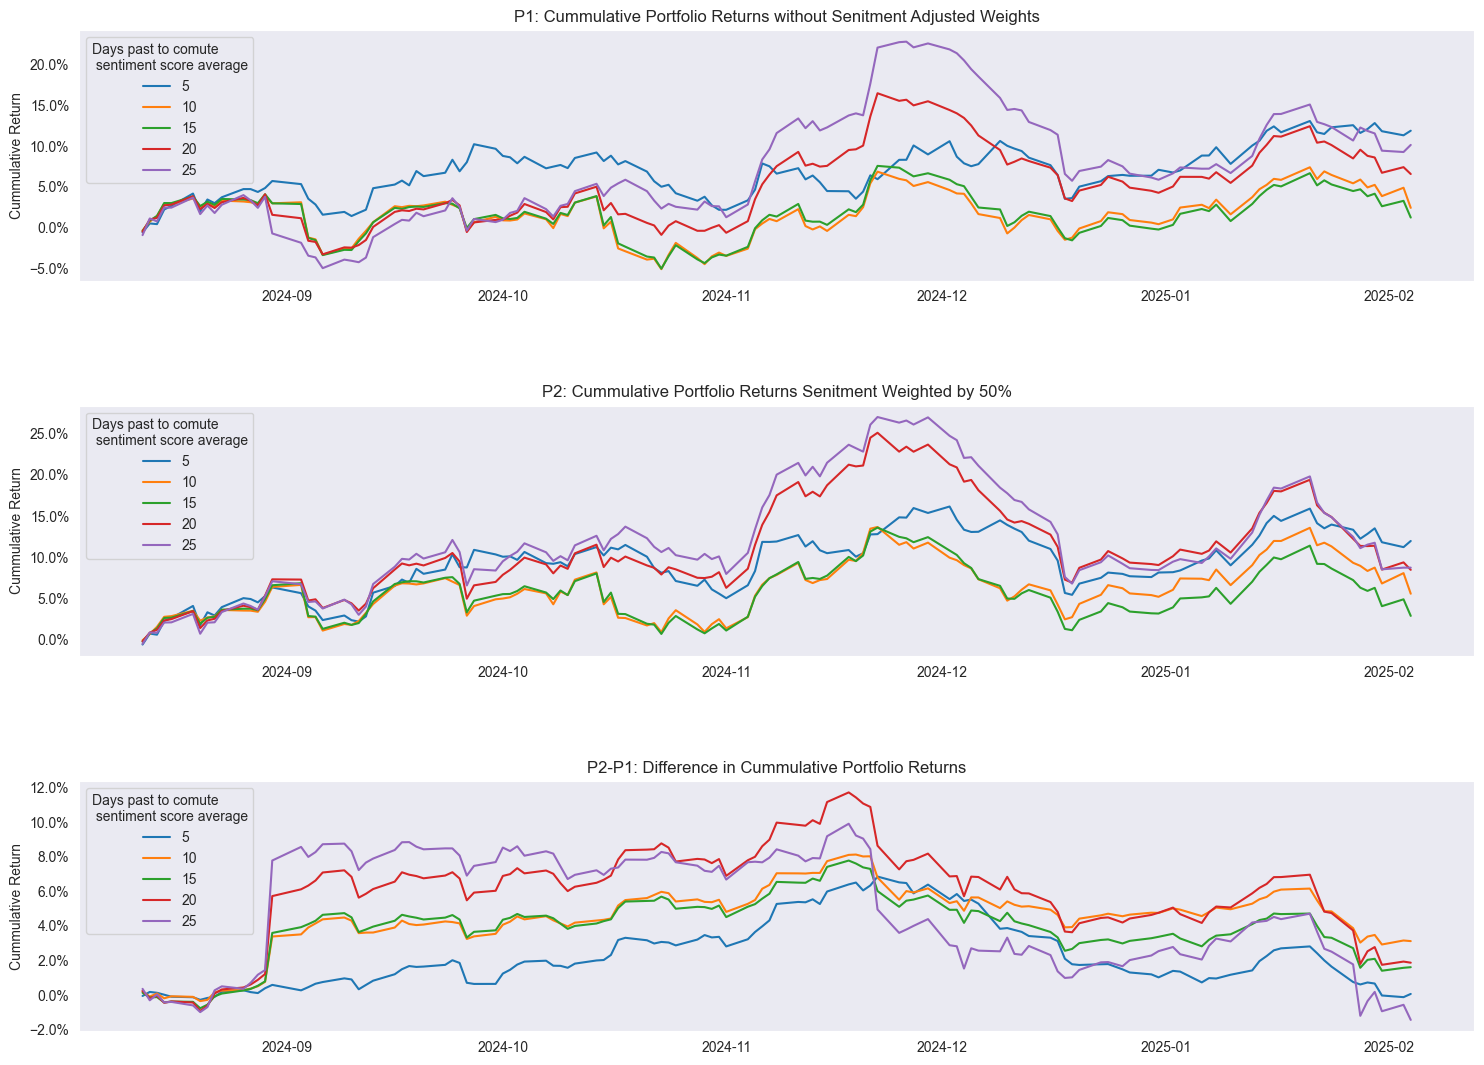

In [383]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(18,13))
plt.subplot(3,1,1)
sns.set_style('dark')
plt.plot(dates1[1], df_normal, label=df_normal.columns)
plt.title("P1: Cummulative Portfolio Returns without Senitment Adjusted Weights")
plt.subplots_adjust(hspace=0.5) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylabel('Cummulative Return')
plt.legend(title='Days past to comute \n sentiment score average')


plt.subplot(3,1,2)
plt.plot(dates1[1], df_treatment,label=df_treatment.columns)
plt.title("P2: Cummulative Portfolio Returns Senitment Weighted by 50%")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.subplots_adjust(hspace=0.5) 
plt.ylabel('Cummulative Return')
plt.legend(title='Days past to comute \n sentiment score average')
           

plt.subplot(3,1,3)
plt.plot(dates1[1],difference, label=df_normal.columns)
plt.title("P2-P1: Difference in Cummulative Portfolio Returns")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.subplots_adjust(hspace=0.5) 
plt.ylabel('Cummulative Return')
plt.legend(title='Days past to comute \n sentiment score average')
plt.savefig('Portfolio_cumulative_returns.png', dpi=300)

- Taking the average of 20 days of sentiment scores yields higher returns

In [382]:
plt.savefig('Portfolio_cumulative_returns.png', dpi=300)

<Figure size 640x480 with 0 Axes>

In [395]:
portfolio_assets=pd.DataFrame({
    'tickers' : tickers,
    'weights': optimal_weights[3]})
portfolio_assets.to_csv('optimal_weights.csv')

In [397]:
portfolio_assets=pd.DataFrame({
    'weights': optimal_weights})

In [409]:
portfolio_assets=pd.DataFrame({
    'tickers' : tickers,
    'weights(5avg)': optimal_weights[0],
    'weights(10avg)': optimal_weights[1],
    'weights(15avg)': optimal_weights[2],
    'weights(20avg)': optimal_weights[3],
    'weights(25avg)': optimal_weights[4]})
portfolio_assets.round(4)#.plot()

,tickers,weights(5avg),weights(10avg),weights(15avg),weights(20avg),weights(25avg)
0,AAP,0.0000,0.0000,0.0000,0.0000,0.0000
1,ARES,0.0000,0.1072,0.0000,0.0000,0.0000
2,BDC,0.1130,0.0000,0.0000,0.0000,0.0000
3,BIGC,0.0000,0.0000,0.0000,0.0000,0.0000
4,CNC,0.0295,0.3522,0.3202,0.1099,0.0000
5,CRM,0.0000,0.0000,0.0000,0.0000,0.0000
6,ESTC,0.0000,0.0000,0.0000,0.0000,0.0000
7,GRPN,0.0000,0.0000,0.0000,0.0000,0.0000
8,JEF,0.0000,0.0000,0.0408,0.0000,0.0000
9,LEG,0.2247,0.0000,0.0847,0.1301,0.2502
